## Some information

The analysis is broken into 3 phases:

* The **Setup phase**: mandatory
* The **Analysis phase**: optional, depending on whether you want to explore different analysis parameters to the *default parameters*
* The **Plotting phase**: desirable, if you want to explore the data

For each set of parameters, two files are created:

* A `.nix` file, which is an intermediate step of the analysis and contains the imaging analysis
* A `.csv` file, which contains the final combined electrophysiological and imaging data

To run the analysis, the underlying data needs to be downloaded from the Zenodo repository (see README) and extracted into the Jupyter notebook folder. The archive contains the following files:

* Imaging files (one `.nix` file per neuron)
* An `excludes.csv` file
* A `Megatable_C.csv` file containing the electrophysiology data corresponding to the imaged cells
* The `.nix` intermediate analysis file for ***default parameters***
* The `.csv` file with the combined electrophysiological and imaging data for ***default parameters***
* An `.xlsx` file containing the individual points corresponding to the Figure in the paper

The `.nix` and `.csv` files corresponding to the *default parameters* used in the study have already been generated and are in the folder.

Therefore, to explore the data with these *default parameters*, run the **Setup phase** but jump directly to the **Plotting phase** (you can skip the Analysis phase).

To explore other analysis parameters, you will have to run the **Analysis phase** with the parameters of interest. This may take some time.

## Setup phase

First, import the necessary packages and modules needed to run the code

In [1]:
import time
import numpy as np
import pandas as pd
from io import StringIO

from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pprint import pprint

import nixio as nix

from ca.nix import *
from ca.img import *
from ca.util import *

Four different ***pulses*** (ap1, ap3, ap10, ap25) were used to evoke dendritic calcium signals:

* ap1 = 1 action potential (AP)
* ap3 = 3 APs @100Hz
* ap10 = 10 APs @ 100Hz
* ap25 = 25 APs @ 100Hz

Pulses were presented via three different ***loops***:

* Loop 1: ap3, ap1, ap10, ap1
* Loop 2: ap3, ap1, ap25, ap3
* Loop 3: ap1, ap25, ap3, ap1, ap10 

Note that *Loop 0* was not used in the study.

Finally, there are two **conditions**:

* Normal acoustic environment (NAE)
    * ages: 10, 11, 13, 14, 15, 16, 17, 18, 60
* Omnidirectional white noise (OWN)
    * ages: 14, 15, 16, 17, 18
    
In the first step, load these parameters.

In [2]:
from ca.experiment import *

pprint(loops)
pprint(pulses)
pprint(ages)

{'0': [3, 10, 25],
 '1': [3, 1, 10, 1],
 '2': [3, 1, 25, 3],
 '3': [1, 25, 3, 1, 10]}
[1, 3, 10, 25]
[10, 11, 13, 14, 15, 16, 17, 18, 60]


In the next step, three important analysis parameters can be defined:

* Variable ***channel***: the analysis can be done with ΔF/R (ΔF<sub>green</sub>/F<sub>red</sub>) or ΔF/F (ΔF<sub>green/green</sub>)
* Variable ***dendritic_length***: minimal dendritic length (in pixels) considered for analysis
* Variable ***pd_timing***: the start and end frames between which the peak ΔF/R (or ΔF/F) was taken

The defaults correspond to the values used in the study.

In [3]:
channel = "red"
dendritic_length = 70
pd_timing = (12, 24)

---

## Analysis phase

To begin, load the `excludes.csv` file, which specifies trials or cells to be excluded from the analysis. Exclusion criteria include:

* Trials with action potential failures
* Drift in the image during the acquisition
* Imaging error during the acquisition
* Cells that were impossible to trace or for which the location of the soma could not be determined post recording
* Animals from litters n < 3
* Initial recordings in which a stepper pulse was used (a more physiological ramp was used for all subsequent experiments)
* Recordings in which there was a large change in temperature in the bath

In [4]:
excludes = None
ep = os.path.join("data/excludes.csv")

if os.path.exists(ep):
    print("Using excludes.csv @ %s" % ep)
    excludes = load_exclude(ep)

Using excludes.csv @ data/excludes.csv


Now that this is defined, the actual analysis can take place.

For this, import the `CaAnalyser` class from the `ca.analyser` module and run the analysis on the data with the given parameters.

The output of this step is a `.nix` file which contains the results of the analysis and the associated metadata. This may take a while...

In [5]:
from ca.analyser import CaAnalyser

analyser = CaAnalyser("data", channel, 10, dendritic_length, False, excludes, pd_timing)
analyser.bg = None
analyser.setup()
analyser.process()
analyser.finish()

if len(analyser.warnings) > 0:
    print("WARNINGS: \n  " + "\n  ".join(analyser.warnings), file=sys.stderr)

print(analyser.filename)

ca-red-bs10-70p-uc-12_24.nix


Now that the analysis of the calcium data is finished, we read the generated data and metadata that was saved to the `.nix` file back into memory.

Then, the imaging data is combined with the electrophysiological data (from `Megatable_C.csv`) into one big .csv file ("gigatable"). This will take a while...

In [6]:
filename = "ca-%s-bs10-%dp-uc-%d_%d.nix" % (channel, dendritic_length, pd_timing[0], pd_timing[1])
nf = nix.File.open(filename, nix.FileMode.ReadOnly)

full = item_of_type(nf.blocks, "dff.full")
b = item_of_type(nf.blocks, "dff.peak")
tag = item_of_type(b.multi_tags, "pulse.avg")

pos = np.array(tag.positions)

fneu = index_of_name(tag.features, "neuron")
fcnd = index_of_name(tag.features, "condition")
fage = index_of_name(tag.features, "age")

params = nf.sections['params']
baseline = params['baseline']
over = params['over']
dlen = params['length']
pst = params['peak-start'] if 'peak-start' in params else None
pnd = params['peak-end'] if 'peak-end' in params else None
bg = params['bg-correction'] if 'bg-correction' in params else None

print("neuron feature @ %d " % fneu)
print("condition feature @ %d " % fcnd)
print("age feature @ %d " % fage)

peak_ind = "_".join(map(str, filter(lambda x: x is not None, [pst, pnd])))

print("baseline: %s" % baseline)
print("over correction: %s" % over)
print("dendrite length: %s" % dlen)
print("background correction: %s" % (bg or 'uncorrected'))
print("peak range: %s" % peak_ind)

gigatable_filename = "img.%s.%s.%s.%s.%s.csv" % (over, baseline, dlen, peak_ind, (bg or 'uc'))
print("Gigatable Filename: %s" % gigatable_filename)

outfile = StringIO('')

print('Neuron,Age,Condition,Over,Length,%s,%s,%s,%s' 
      % tuple(map(lambda t: t.name.split('.')[0], tag.references)),
      file=outfile)

for p in pos:
    p = int(p)
    nid = tag.retrieve_feature_data(p, fneu)[0]
    neuron = neuron_name(nid)
    cid = tag.retrieve_feature_data(p, fcnd)[0]
    condition = ['control', 'noisebox'][cid]
    age = tag.retrieve_feature_data(p, fage)[0]
    dlen = neuron_dendrite_length(full, neuron)
    print('%s,%d,%s,%s,%s,' % (neuron, age, condition, over, dlen), end='', file=outfile)
    data = [tag.retrieve_data(p, idx)[0] for idx, _ in enumerate(pulses)]
    print(",".join(map(str, data)), file=outfile)
    
# Now we construct the giga table
outfile.seek(0)

imga = pd.read_csv(outfile)

# read the mega table
mega = pd.read_csv("data/Megatable_C.csv")

result = pd.merge(mega, imga, how='inner', on=['Neuron'])
result.reset_index(inplace=True)

rename = {c: c[:-2] for c in result.columns if c.endswith("_x")}
result.rename(columns=rename, inplace=True)
    
# write the gigatable
result.to_csv(gigatable_filename, index=False)

# close the nix file again
nf.close()

neuron feature @ 2 
condition feature @ 1 
age feature @ 0 
baseline: 10
over correction: red
dendrite length: 70
background correction: uncorrected
peak range: 12_24
Gigatable Filename: img.red.10.70.12_24.uc.csv


---

## Plotting phase

To explore and plot the data, we read the combined data (calcium and ephys data) from the "gigatable" `.csv` file into a pandas dataframe.

In [7]:
gigatable_filename = "img.%s.10.%d.%d_%d.uc.csv" % (channel, dendritic_length, pd_timing[0], pd_timing[1])
df = pd.read_csv(gigatable_filename)

The following code plots 3 graphs on the basis of chosen parameters:

* Peak calcium signal during development in the NAE condition
* Peak calcium signal during development in the OWN condition
* Peak calcium signal during development in NAE and OWN

Default parameters are:
* ΔF<sub>green</sub>/F<sub>red</sub>
* minimum dendritic length = 70
* peak detection window: frame 12, frame 24.

The graphs show the mean ± standard deviation.

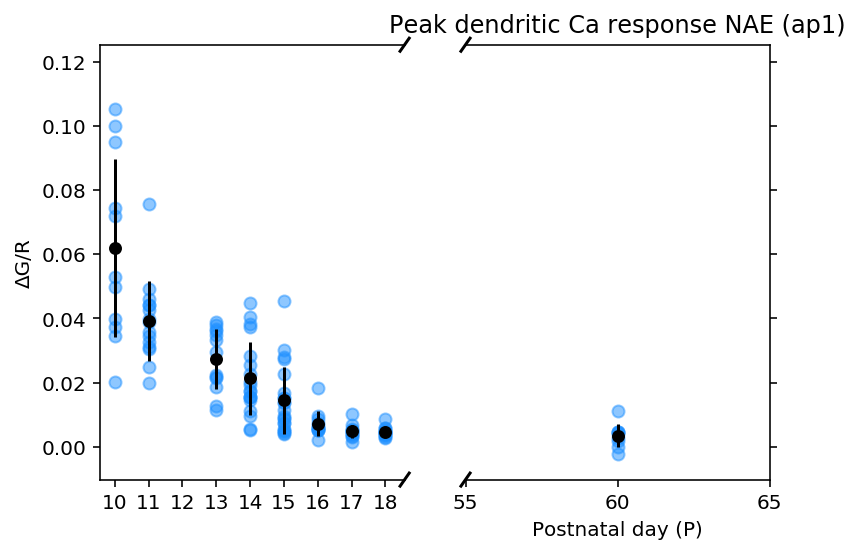

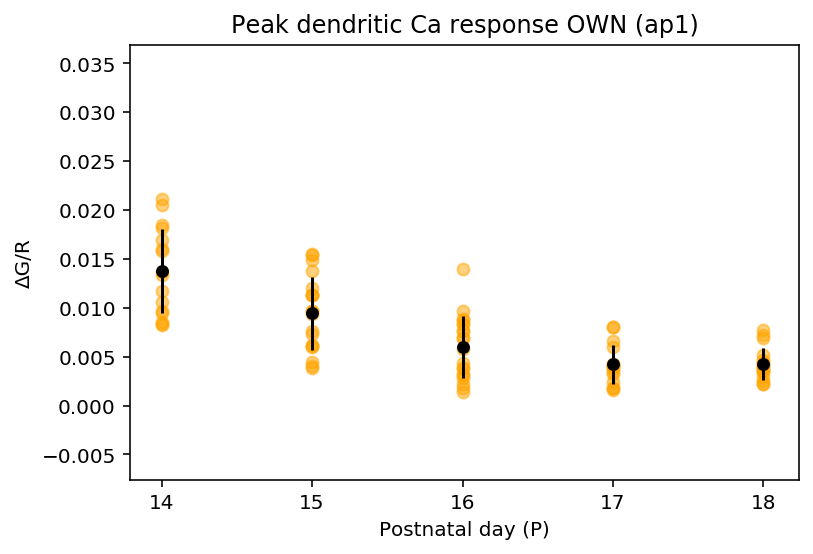

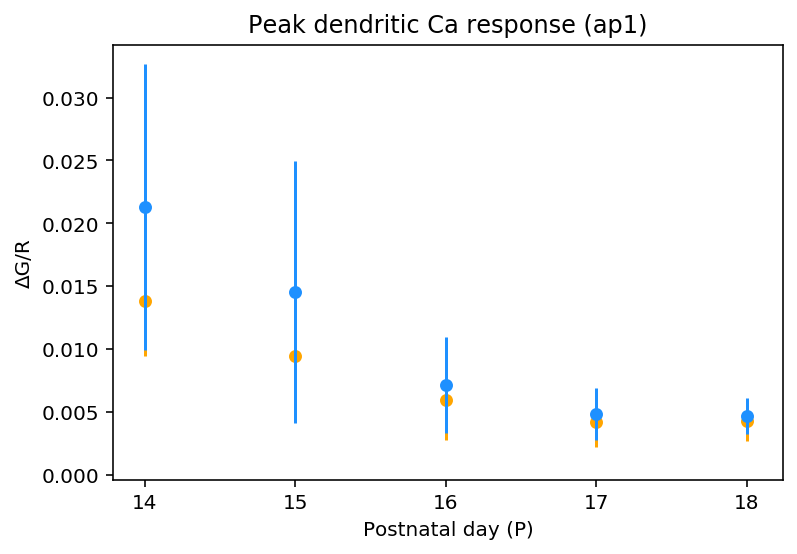

In [8]:
pulse = "ap1"

over = df.Over.loc[1]
dff = u'ΔG/R' if over == 'red' else u'ΔG/G'

#control
cdat = df.loc[df.Condition == 'control']
cages = np.unique(cdat.Age)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

aged = cdat.groupby(['Age'])

for age in cages:
    ax = ax1 if age < 20 else ax2
    ser = aged.get_group(age)
    d = np.array(ser[pulse])
    ax.scatter(np.tile(age, d.shape[0]), d, color='dodgerblue', alpha=0.5)
    sem = np.nanstd(d)
    mean = np.nanmean(d)
    ax.scatter(age, mean, color='black', s=30)
    ax.errorbar(age, mean, yerr=sem, color='black', capthick=1)

ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

ax1.set_xticks([10, 11, 12, 13, 14, 15, 16, 17, 18])
ax2.set_xticks([55, 60, 65])

ax2.set_xlabel('Postnatal day (P)')
ax1.set_ylabel(dff)

nbcond = get_nb_condition(df)

ndat = df.loc[df.Condition == nbcond]
nages = np.unique(ndat.Age)
aged = ndat.groupby(['Age'])
plt.title(f"Peak dendritic Ca response NAE ({pulse})")

# noisebox
plt.figure()
for age in nages:
    ser = aged.get_group(age)
    d = np.array(ser[pulse])
    plt.scatter(np.tile(age, d.shape[0]), d, color='orange', alpha=0.5)
    sem = np.nanstd(d)
    mean = np.nanmean(d)
    plt.scatter(age, mean, color='black', s=30)
    plt.errorbar(age, mean, yerr=sem, color='black', capthick=1)

plt.title(f"Peak dendritic Ca response OWN ({pulse})")
plt.xlabel('Postnatal day (P)')
plt.ylabel(dff)
plt.xticks([a for a in nages])

#both
common = list(set(cages) & set(nages))

gd = df.groupby(['Age', 'Condition'])

plt.figure()
offset = 0.0
for age in common:
    nb = gd.get_group((age, nbcond))
    nb_sem = np.nanstd(nb[pulse]) # stats.sem(nb[args.pulse], nan_policy='omit')
    nb_mean = np.nanmean(nb[pulse])
    plt.scatter(age+offset, nb_mean, color='orange', s=30)
    plt.errorbar(age+offset, nb_mean, yerr=nb_sem, color='orange', capthick=1)

    cd = gd.get_group((age, 'control'))
    cd_sem = np.std(cd[pulse]) # stats.sem(cd[args.pulse], nan_policy='omit')
    cd_mean = np.nanmean(cd[pulse])
    plt.scatter(age-offset, cd_mean, color='dodgerblue', s=30)
    plt.errorbar(age-offset, cd_mean, yerr=cd_sem, color='dodgerblue', capthick=1)

plt.title(f'Peak dendritic Ca response ({pulse})')
plt.xlabel('Postnatal day (P)')
plt.ylabel(dff)
plt.xticks(common)
plt.show()


The following code can be used to plot the peak calcium signal (on the basis of chosen parameters) vs. a given electrophysiological parameter.

There are 3 plotting paramaters:

1. **Select the *electrophysiological* parameter to plot**

    The following electrophysiological parameters can be plotted by entering the relevant string in the variable `ephys`:

    * Resting membrane potential (mV): enter the string `Vm rest`
    * Action potential size from baseline (mV): enter the string `AP size baseline`
    * Action potential width from baseline (ms): enter the string `AP width baseline`
    * Action potential threshold (mV): enter the string `Threshold`
    * Action potential size from threshold (mV): enter the string `AP size threshold`
    * Action potential width from threshold (ms): enter the string `AP width threshold`
    * Size of the depolarising after-potential (DAP) or after-hyperpolarisation (AHP) (mV): enter the string `DAP/AHP size`
    * Half time decay of the depolarising after-potential (DAP) (ms): enter the string `DAP half time decay`
    * Half-width of the after-hyperpolarisation (AHP) (ms): enter the string `AHP half-width`
    * Half time decay of the after-hyperpolarisation (AHP) (ms): enter the string `AHP half time decay`
    * Size of the last subthreshold event before threshold (mV): enter the string `Last sub size`
    * Width of the last subthreshold event before threshold (ms): enter the string `Last sub width`
    * Input resistance estimated from a stepper pulse (MOhm): enter the string `Rin stepper`
    * Input resistance estimated from the IV curve (MOhm): enter the string `Rin IV`
    * Membrane time constant (onset) (ms): enter the string `tau onset`
    * Membrane time constant (offset) (ms): enter the string `tau offset`
    * Current threshold (pA): enter the string `Current threshold`


2. **Select the *pulse* to be plotted**
    
    Enter one of the following pulses as a string: `ap1`, `ap3`, `ap10`, `ap25`
   
   
3. **Select the *age* to be plotted**

    By default, all ages of the NAE condition are plotted (`age` = `None`).
    To plot one or several ages, enter this as a list, e.g. (`10, 11, 13`).
    
    
4. **Select whether to include the data of the *OWN* condition**

    By default, OWN data is not included (`args_noisebox` = `False`).
    To include the OWN data into the plot, change this to `True`


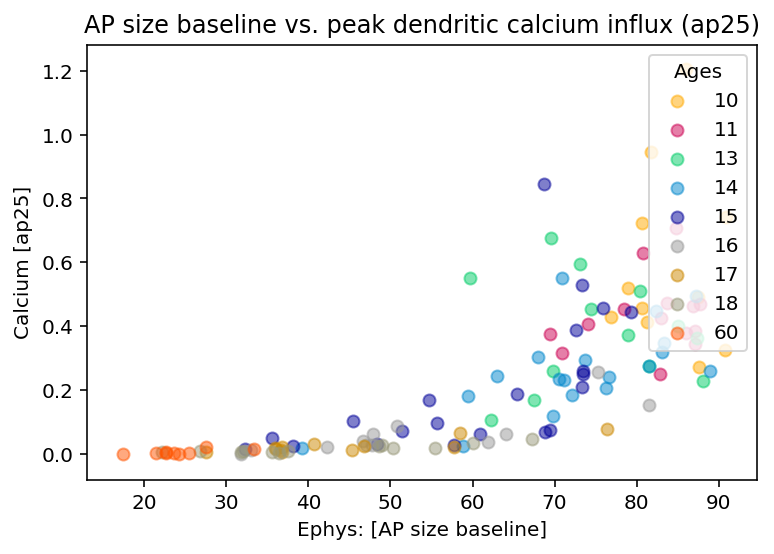

In [9]:
ephys = 'AP size baseline'
pulse = 'ap25'
age = None
args_noisebox = False


if age is not None:
    data = df.loc[df['Age'].isin(list(map(lambda a: int(a), age)))]
else:
    data = df

nbcond = get_nb_condition(data)
control = data.loc[data['Condition'] == "control"]
noisebox = data.loc[data['Condition'] == nbcond]

ages_control = set(control["Age"])
for age in sorted(ages_control):
    dat = control.loc[control["Age"] == age]
    color = list(map(lambda x: x/0xFF, age_to_color[age]))
    plt.scatter(dat[ephys], dat[pulse], color=color, alpha=0.5, label=str(age))
    
# plt.scatter(control[ephys], control[pulse], color=list(col_age_to_color(control)), alpha=0.5, label=control['Age'])
    
if args_noisebox:
    ages_noisebox = set(noisebox["Age"])
    for age in sorted(ages_noisebox):
        dat = noisebox.loc[noisebox["Age"] == age]
        color = list(map(lambda x: x/0xFF, age_to_color[age]))
        plt.scatter(dat[ephys], dat[pulse], color=color, alpha=0.5, facecolors='none',
        marker='D', lw=1.2, label=str(age) + "_NB")


plt.title(f'{ephys} vs. peak dendritic calcium influx ({pulse})')
plt.ylabel('Calcium [%s]' % pulse)
plt.xlabel('Ephys: [%s]' % ephys)
plt.legend(loc="upper right", title="Ages")
plt.show()

The second plotting code can be used to plot two electrophysiological parameters against one another, with an additional colour code for the peak calcium signal.

There are 5 plotting paramaters:

1. **Select the first *electrophysiological* parameter to plot**

    The following electrophysiological parameters can be plotted by entering the relevant string:

    * Resting membrane potential (mV): enter the string `Vm rest`
    * Action potential size from baseline (mV): enter the string `AP size baseline`
    * Action potential width from baseline (ms): enter the string `AP width baseline`
    * Action potential threshold (mV): enter the string `Threshold`
    * Action potential size from threshold (mV): enter the string `AP size threshold`
    * Action potential width from threshold (ms): enter the string `AP width threshold`
    * Size of the depolarising after-potential (DAP) or after-hyperpolarisation (AHP) (mV): enter the string `DAP/AHP size`
    * Half time decay of the depolarising after-potential (DAP) (ms): enter the string `DAP half time decay`
    * Half-width of the after-hyperpolarisation (AHP) (ms): enter the string `AHP half-width`
    * Half time decay of the after-hyperpolarisation (AHP) (ms): enter the string `AHP half time decay`
    * Size of the last subthreshold event before threshold (mV): enter the string `Last sub size`
    * Width of the last subthreshold event before threshold (ms): enter the string `Last sub width`
    * Input resistance estimated from a stepper pulse (MOhm): enter the string `Rin stepper`
    * Input resistance estimated from the IV curve (MOhm): enter the string `Rin IV`
    * Membrane time constant (onset) (ms): enter the string `tau onset`
    * Membrane time constant (offset) (ms): enter the string `tau offset`
    * Current threshold (pA): enter the string `Current threshold`
    
    
2. **Select the second *electrophysiological* parameter to plot**

    Enter a string from the same list as above


3. **Select the *pulse* to be plotted**
    
    Enter one of the following pulses as a string: `ap1`, `ap3`, `ap10`, `ap25`
   
   
4. **Select the *age* to be plotted**

    By default, all ages of the NAE condition are plotted (`age` = `None`).
    To plot one or several ages, enter this as a list, e.g. (`10, 11, 13`).
    
    
5. **Select whether to include the data of the *OWN* condition**

    By default, OWN data is not included (`args_noisebox` = `False`).
    To include the OWN data into the plot, change this to `True`

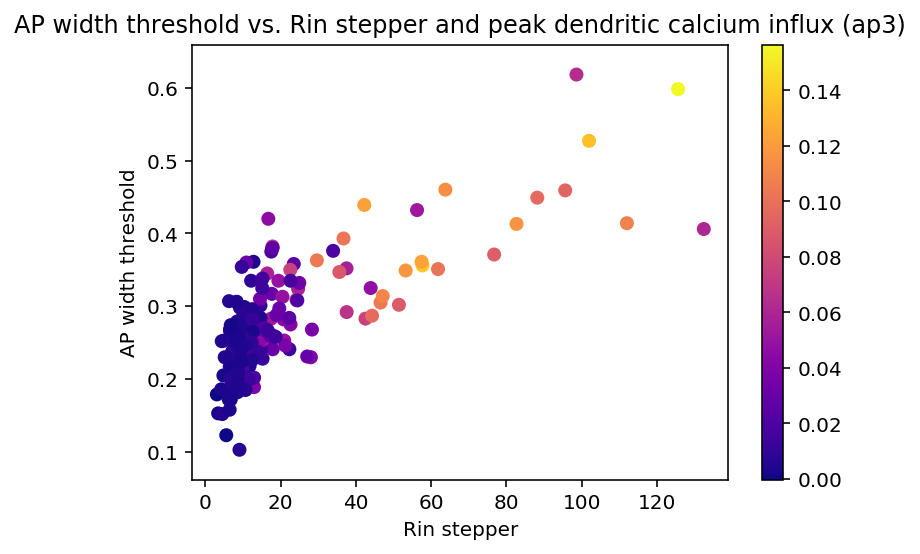

In [11]:
ephys_1 = 'Rin stepper'
ephys_2 = 'AP width threshold'
pulse = "ap3"
age = None
args_noisebox = False

if age is not None:
    data = df.loc[df['Age'].isin(list(map(lambda a: int(a), age)))]
else:
    data = df

plt.scatter(data[ephys_1], data[ephys_2], c=data[pulse], cmap='plasma')

if args_noisebox:
    plt.scatter(noisebox[ephys_1], noisebox[ephys_2], c=noisebox[pulse],
                facecolors='none', marker='+', lw=1.2, cmap='plasma')

plt.title(f'{ephys_2} vs. {ephys_1} and peak dendritic calcium influx ({pulse})')
plt.xlabel(ephys_1)
plt.ylabel(ephys_2)
plt.colorbar()

plt.show()

Thanks!